This is a Convolutional GAN with "moment stabilization" based off of the "Intro to GANs" Lesson from the Udacity Deep Learning Foundations Nanodegree: https://github.com/udacity/deep-learning/blob/master/gan_mnist/Intro_to_GANs_Solution.ipynb. 

In [1]:
%matplotlib inline
import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy.misc
import random
from scipy import ndimage
import cv2
from PIL import Image

In [2]:
# path = "pokeballs2/"
# pokemon = []
# for file in os.listdir(path):
#     if file.endswith('.png'):
#         if file.startswith('._'):
#             pic_path = path + str(file)[2:]
#         else:
#             pic_path = path + str(file)                                                                        
#         im = scipy.misc.imread(pic_path, flatten=False, mode='RGB')
        
#         image = np.asarray(im)
#         pokemon.append(image)

In [3]:
# (h, w) = pokemon[0].shape[:2]
# cols = 100
# rows = 100
# center = (w / 2, h / 2)

In [4]:
# for i in range(len(pokemon)):
#     path = './rotated/'
#     save_path = path + str(i) + '.png'
#     scipy.misc.imsave(save_path, pokemon[i][14:86, 4:76])
    
#     M1 = cv2.getRotationMatrix2D((cols/2,rows/2),3,1)
#     dst1 = cv2.warpAffine(pokemon[i],M1,(cols,rows))
#     save_path1 = path + '3' + str(i) + '.png'
#     scipy.misc.imsave(save_path1, dst1[14:86, 4:76])
    
#     M2 = cv2.getRotationMatrix2D((cols/2,rows/2),5,1)
#     dst2 = cv2.warpAffine(pokemon[i],M2,(cols,rows))
#     save_path2 = path + '5' + str(i) + '.png'
#     scipy.misc.imsave(save_path2, dst2[14:86, 4:76])
    
#     M3 = cv2.getRotationMatrix2D((cols/2,rows/2),7,1)
#     dst3 = cv2.warpAffine(pokemon[i],M3,(cols,rows))
#     save_path3 = path + '7' + str(i) + '.png'
#     scipy.misc.imsave(save_path3, dst3[14:86, 4:76])
    
#     Mneg1 = cv2.getRotationMatrix2D((cols/2,rows/2),-3,1)
#     dstn1 = cv2.warpAffine(pokemon[i],Mneg1,(cols,rows))
#     save_pathn1 = path + '3n' + str(i) + '.png'
#     scipy.misc.imsave(save_pathn1, dstn1[14:86, 4:76])
    
#     Mneg2 = cv2.getRotationMatrix2D((cols/2,rows/2),-5,1)
#     dstn2 = cv2.warpAffine(pokemon[i],Mneg2,(cols,rows))
#     save_pathn2 = path + '5n' + str(i) + '.png'
#     scipy.misc.imsave(save_pathn2, dstn2[14:86, 4:76])
    
#     Mneg3 = cv2.getRotationMatrix2D((cols/2,rows/2),-7,1)
#     dstn3 = cv2.warpAffine(pokemon[i],Mneg3,(cols,rows))
#     save_pathn3 = path + '7n' + str(i) + '.png'
#     scipy.misc.imsave(save_pathn3, dstn3[14:86, 4:76])
    

In [5]:
path = "rotated/"
pokemon = []
for file in os.listdir(path):
    if file.endswith('.png'):
        if file.startswith('._'):
            pic_path = path + str(file)[2:]
        else:
            pic_path = path + str(file)                                                                        
        im = scipy.misc.imread(pic_path, flatten=False, mode='RGB')
        
        image = np.asarray(im)
        pokemon.append(image)

In [6]:
len(pokemon)

17676

In [7]:
def batch(data, batch_size):
    random.shuffle(data)
    for index in range(0, len(data), batch_size):
        yield data[index: index + batch_size]

In [8]:
def model_inputs(image_width, image_height, image_channels, z_dim):

    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    Z = tf.placeholder(tf.float32, [None, z_dim])
    
    return real_input, Z

In [9]:
def generator(z, out_channel_dim, alpha=0.1, reuse1=False):
    strides_ = [1,2,2,1]
    epsilon = 1e-3
    with tf.variable_scope('generator', reuse=reuse1):
        # TODO: Implement Function
        batch_size = tf.shape(z)[0]
        
        w_ = tf.get_variable('gener_a_', [100, 325*9*9])
        w0 = tf.get_variable('gener_a', [3, 3, 512, 9*9*13], initializer = tf.contrib.layers.xavier_initializer(), dtype=tf.float32)
        w1 = tf.get_variable('gener_a1', [3, 3, 256, 512], initializer = tf.contrib.layers.xavier_initializer(), dtype=tf.float32)
        w2 = tf.get_variable('gener_a2', [3, 3, 128, 256], initializer = tf.contrib.layers.xavier_initializer(), dtype=tf.float32)
        w3 = tf.get_variable('gener_a3', [3, 3, 3, 128], initializer = tf.contrib.layers.xavier_initializer(), dtype=tf.float32)     
        b1 = tf.get_variable('b1', [512], initializer = tf.zeros_initializer())
        b2 = tf.get_variable('b2', [256], initializer = tf.zeros_initializer())
        b3 = tf.get_variable('b3', [128], initializer = tf.zeros_initializer())
        b4 = tf.get_variable('b4', [3], initializer = tf.zeros_initializer())
 

        h0 = tf.matmul(z, w_)
        h0 = tf.reshape(h0, [batch_size, 5, 5, 9*9*13])
        
        h1 = tf.nn.conv2d_transpose(h0, w0, [batch_size, 9, 9, 512], strides=[1,2,2,1], padding='SAME')
        h1 = tf.add(h1, b1)
        batch_mean1, batch_var1 = tf.nn.moments(h1,[0])
        scale1 = tf.get_variable('sc1', [512], initializer= tf.ones_initializer())
        beta1 = tf.get_variable('bet1', [512], initializer=tf.zeros_initializer())
        h1 = tf.nn.batch_normalization(h1, batch_mean1, batch_var1, beta1, scale1, epsilon)
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.nn.conv2d_transpose(h1, w1, [batch_size, 18, 18, 256], strides=[1,2,2,1], padding='SAME' )
        h2 = tf.add(h2, b2)
        batch_mean2, batch_var2= tf.nn.moments(h2,[0])
        scale2 = tf.get_variable('sc2', [256], initializer= tf.ones_initializer())
        beta2 = tf.get_variable('bet2', [256], initializer=tf.zeros_initializer())
        h2 = tf.nn.batch_normalization(h2, batch_mean2, batch_var2, beta2, scale2, epsilon)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.nn.conv2d_transpose(h2, w2, [batch_size, 36, 36, 128], strides=strides_, padding='SAME')
        h3 = tf.add(h3, b3)
        batch_mean3, batch_var3 = tf.nn.moments(h3,[0])
        scale3 = tf.get_variable('sc3', [128], initializer= tf.ones_initializer())
        beta3 = tf.get_variable('bet3', [128], initializer=tf.zeros_initializer())
        h3 = tf.nn.batch_normalization(h3, batch_mean3, batch_var3, beta3, scale3, epsilon)            
        h3 = tf.maximum(alpha * h3, h3)  
        logits = tf.nn.conv2d_transpose(h3, w3, [batch_size, 72, 72, 3], strides=strides_, padding='SAME')       
        logits = tf.add(logits, b4)
        out = tf.tanh(logits)
        
        return out, logits


In [10]:
def discriminator(images, reuse=False, alpha=0.1):
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.conv2d(images, 128, 3, strides=1, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(), bias_initializer=tf.zeros_initializer())
        h1 = tf.nn.avg_pool(h1, [1,2,2,1], [1,2,2,1], padding='SAME')
        h1 = tf.nn.dropout(h1, 0.5)
        h1 = tf.maximum(alpha * h1, h1)
        h2 = tf.layers.conv2d(h1, 256, 3, strides=1, padding='SAME' , kernel_initializer=tf.contrib.layers.xavier_initializer(), bias_initializer=tf.zeros_initializer())
        h1 = tf.nn.avg_pool(h2, [1,2,2,1], [1,2,2,1], padding='SAME')
        h2 = tf.maximum(alpha * h2, h2)
        h3 = tf.layers.conv2d(h2, 512, 3, strides=1, padding='SAME' , kernel_initializer=tf.contrib.layers.xavier_initializer(), bias_initializer=tf.zeros_initializer())
        h3 = tf.nn.avg_pool(h3, [1,2,2,1], [1,2,2,1], padding='SAME')
        h3 = tf.maximum(alpha * h3, h3)
        flat = tf.reshape(h3, (-1, 9*9*512))
        flat = tf.nn.dropout(flat, 0.5)
        
        logits = tf.layers.dense(flat, 1 , kernel_initializer=tf.contrib.layers.xavier_initializer(), bias_initializer=tf.zeros_initializer())
        out = tf.sigmoid(logits)

        return out, logits

<h2>Hyperparameters</h2>

In [11]:
input_size = pokemon[0].shape[0] * pokemon[0].shape[1]
z_dim = 100
out_channel_dim = 3
h_dim = 72
w_dim = 72
smoothing = 0.1
batch_size = 32
epochs = 200

<h2>Moments</h2>
We multiply the moments by 0.001 to keep them roughly in line with the original generator loss.

In [12]:
tf.reset_default_graph()
input_real, input_z = model_inputs(w_dim, h_dim, out_channel_dim, z_dim)
g_model, g_logits = generator(input_z, out_channel_dim)
d_model_real, d_logits_real = discriminator(input_real)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

In [13]:
g_mean, g_var = tf.nn.moments(g_model, axes=[0])
d_mean, d_var = tf.nn.moments(input_real, axes=[0])

mean_diff = tf.reduce_sum(tf.abs(g_mean - d_mean))
var_diff = tf.reduce_sum(tf.abs(g_var - d_var))

mean_diff = mean_diff *0.001
var_diff = var_diff * 0.001

In [14]:
d_loss_real = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smoothing))) 
d_loss_fake = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
g_loss_mod = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

g_loss = g_loss_mod + mean_diff + var_diff
d_loss = d_loss_real + d_loss_fake

In [15]:
t_vars = tf.trainable_variables()
d_vars = [var for var in t_vars if var.name.startswith('discrim')]
g_vars = [var for var in t_vars if var.name.startswith('gene')]

with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
    g_train_opt = tf.train.AdamOptimizer(0.0002).minimize(g_loss, var_list=g_vars)

d_train_opt = tf.train.AdamOptimizer(0.0001).minimize(d_loss, var_list=d_vars)

In [16]:
!mkdir checkpoints

A subdirectory or file checkpoints already exists.


<h2>Modified Loss Function</h2>

In [17]:
samples = []
losses = []
var_losses = []
mean_losses = []
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(len(pokemon)//batch_size):
            poke_batch = next(batch(pokemon, batch_size))
            poke_batch = ((np.array(poke_batch) / 255.) - 0.5) * 2
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            _ = sess.run(g_train_opt, feed_dict={input_real: poke_batch, input_z: batch_z})
            _ = sess.run(d_train_opt, feed_dict={input_real: poke_batch, input_z: batch_z})
        
        train_loss_g = g_loss_mod.eval({input_z: batch_z, input_real: poke_batch})
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: poke_batch})
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g)) 
        var_diff1 = var_diff.eval(session=sess, feed_dict={input_real: poke_batch, input_z: batch_z})
        mean_diff1 = mean_diff.eval(session=sess, feed_dict={input_real: poke_batch, input_z: batch_z})
        print('Var_diff: ' +str(var_diff1) + ' Mean_diff: ' +str(mean_diff1))
        losses.append((train_loss_d, train_loss_g))
        var_losses.append(var_diff1)
        mean_losses.append(mean_diff1)
        sample_z = np.random.uniform(-1, 1, size=(32, z_dim))
        gen_samples, _ = sess.run(
                       generator(input_z, out_channel_dim, reuse1=True),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/200... Discriminator Loss: 1.1948... Generator Loss: 1.1640
Var_diff: 0.653535 Mean_diff: 0.861459
Epoch 2/200... Discriminator Loss: 1.2849... Generator Loss: 1.0258
Var_diff: 0.579554 Mean_diff: 0.828598
Epoch 3/200... Discriminator Loss: 1.2680... Generator Loss: 0.9516
Var_diff: 0.637749 Mean_diff: 0.875442
Epoch 4/200... Discriminator Loss: 1.3515... Generator Loss: 0.9856
Var_diff: 0.55749 Mean_diff: 0.608865
Epoch 5/200... Discriminator Loss: 1.4203... Generator Loss: 0.6868
Var_diff: 0.625075 Mean_diff: 0.741085
Epoch 6/200... Discriminator Loss: 1.2711... Generator Loss: 0.9644
Var_diff: 0.669918 Mean_diff: 0.812145
Epoch 7/200... Discriminator Loss: 1.2178... Generator Loss: 0.9899
Var_diff: 0.602904 Mean_diff: 0.657559
Epoch 8/200... Discriminator Loss: 1.2534... Generator Loss: 0.8907
Var_diff: 0.558853 Mean_diff: 0.594389
Epoch 9/200... Discriminator Loss: 1.2279... Generator Loss: 1.0048
Var_diff: 0.562575 Mean_diff: 0.639874
Epoch 10/200... Discriminator Loss: 1.

Epoch 78/200... Discriminator Loss: 0.8330... Generator Loss: 1.6771
Var_diff: 0.647329 Mean_diff: 0.748411
Epoch 79/200... Discriminator Loss: 0.9568... Generator Loss: 1.9811
Var_diff: 0.703182 Mean_diff: 0.799353
Epoch 80/200... Discriminator Loss: 0.9029... Generator Loss: 1.9946
Var_diff: 0.610237 Mean_diff: 0.798739
Epoch 81/200... Discriminator Loss: 0.8090... Generator Loss: 1.8140
Var_diff: 0.638674 Mean_diff: 0.670973
Epoch 82/200... Discriminator Loss: 0.9903... Generator Loss: 1.5418
Var_diff: 0.61015 Mean_diff: 0.681921
Epoch 83/200... Discriminator Loss: 0.9249... Generator Loss: 1.6856
Var_diff: 0.676575 Mean_diff: 0.795741
Epoch 84/200... Discriminator Loss: 0.8808... Generator Loss: 1.9651
Var_diff: 0.561456 Mean_diff: 0.65725
Epoch 85/200... Discriminator Loss: 0.8745... Generator Loss: 1.7039
Var_diff: 0.652949 Mean_diff: 0.796841
Epoch 86/200... Discriminator Loss: 0.8008... Generator Loss: 1.9776
Var_diff: 0.688591 Mean_diff: 0.753887
Epoch 87/200... Discriminator 

Epoch 154/200... Discriminator Loss: 0.7225... Generator Loss: 2.8592
Var_diff: 0.78191 Mean_diff: 1.2873
Epoch 155/200... Discriminator Loss: 0.6676... Generator Loss: 2.8340
Var_diff: 0.688516 Mean_diff: 0.7573
Epoch 156/200... Discriminator Loss: 0.7750... Generator Loss: 2.4994
Var_diff: 0.749886 Mean_diff: 0.811873
Epoch 157/200... Discriminator Loss: 0.7966... Generator Loss: 2.8399
Var_diff: 0.746186 Mean_diff: 0.860434


KeyboardInterrupt: 

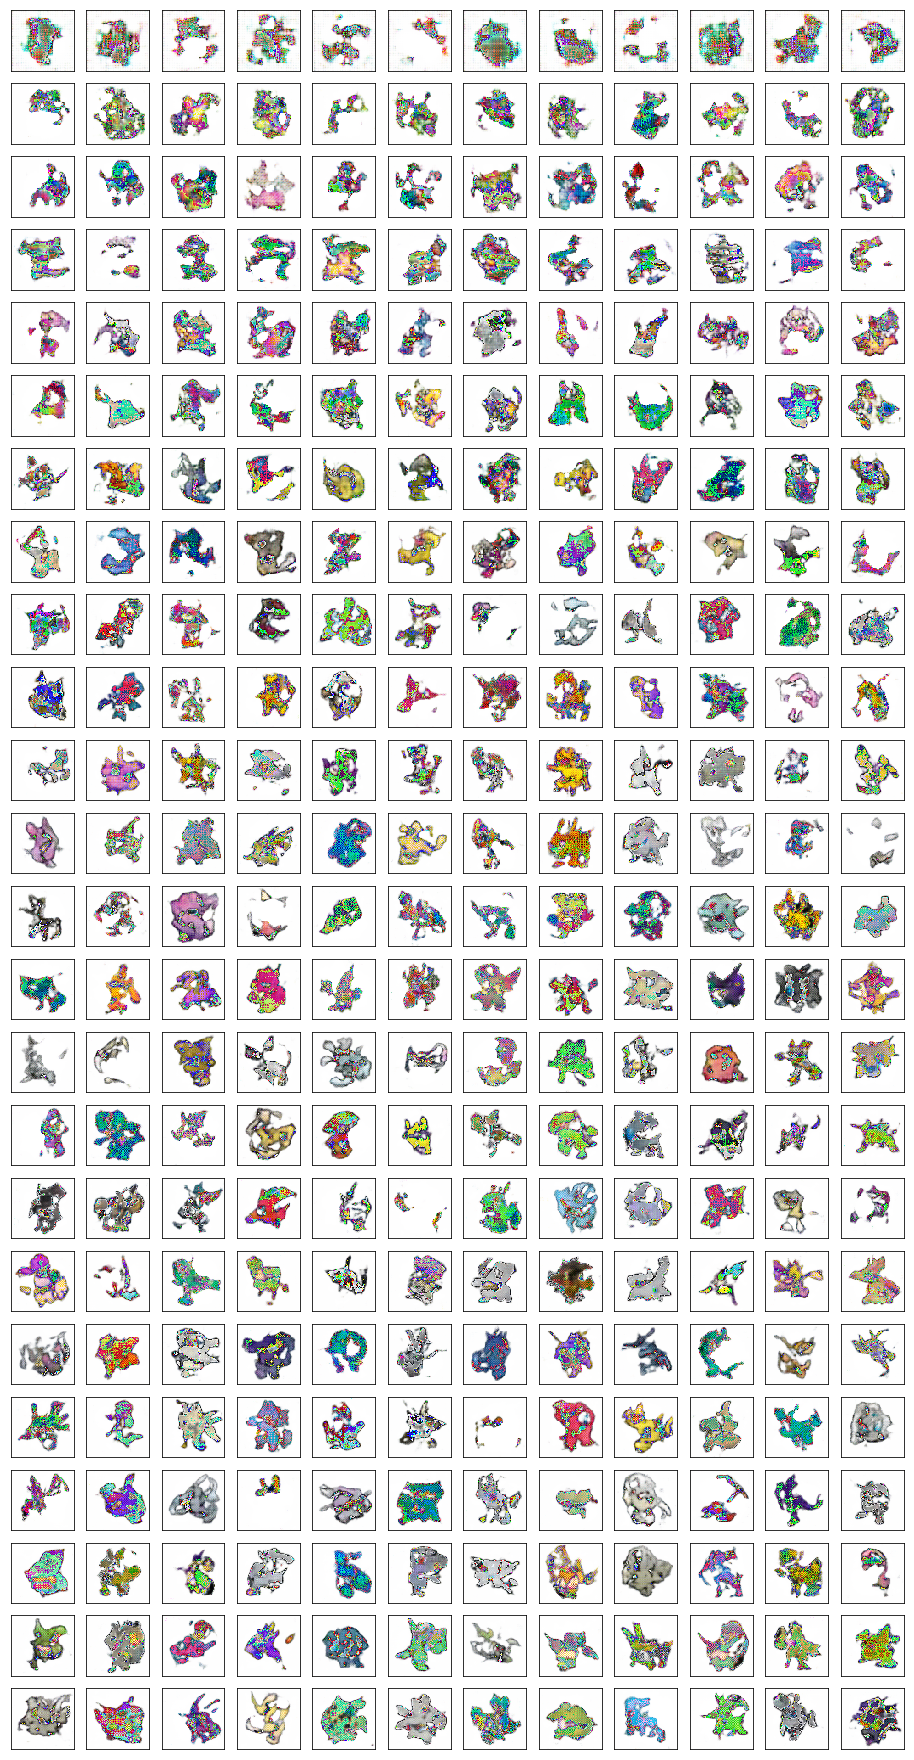

In [18]:
rows, cols = 24, 12
fig, axes = plt.subplots(figsize=(16,32), nrows=rows, ncols=cols, sharex=True, sharey=True)
samples2 = []
for sample in samples:
    samples2.append( ((sample /2.0 + 0.5) * 255).astype(np.int))

for sample, ax_row in zip(samples[::int(len(samples2)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)